# Modelling stock returns and volatility


## Procedure

Building a volatility model consists of several steps.

1. Specify the mean equation. In our case, we need to investigate the mean of our returns and check for serial
dependence. If required, we can fit a model and remove linear dependence structures through filtering. Technically,
we can stop here and use the model to do forecasts, however, we have seen that volatility changes over time and needs
adequate treatment.

2. In the next step, test the residuals for ARCH/GARCH effects and specify a volatility model. In most cases, a low order
GARCH model is used, e.g. GARCH(1,1).

## Setup - Data Foundation and Return Series

In the first step, load the data, compute log-returns and visualize the data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model


In [3]:
df_price = pd.read_csv('BMW.csv')
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price.set_index('Date', inplace=True)

df_returns = df_price.pct_change().dropna()

df_log_price = np.log(df_price)
df_log_returns = df_log_price.diff(1).dropna()

df_log_returns.head

log_return_adj_close = df_log_returns['Adj Close']*100


/home/dm/Desktop/Project_M/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


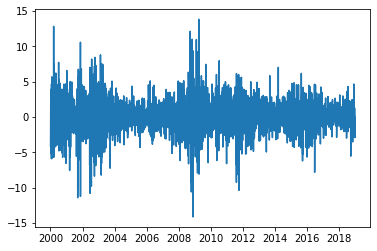

In [4]:
plt.plot(log_return_adj_close)
plt.show()


As was mentioned in the previous exercises on stylized facts, we can clearly see volatility clusters which are
characteristic for financial time series.


## Test for Stationarity and Serial Correlation

By computing the returns we actually differenced the price series and normed it. Therefore, we may assume that the
time series is stationary. Nevertheless, verify this via the Augmented-Dickey Fuller test which is a test whether
unit roots are present.

$$H_0:$$ the series is a unit-root process <br/>
$$H_1:$$ the data is (trend-)stationary

In [5]:
adfuller(log_return_adj_close)[0:2]

(-12.754557032618447, 8.393831708091259e-24)

The first value of the output is the ADF-Statistic, the second line displays the p-value. Clearly, $H_0$ is rejected
with a diminishing p-value which implies stationarity of our time series data sample.

For more details on ADF see
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Next, check plot the acf function and see if any lags are significant.

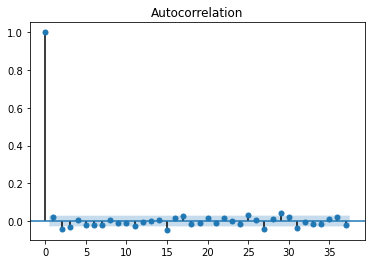

In [6]:
acf_plt = plot_acf(log_return_adj_close)


Based on the plot it seems that the 2. and 3. lag are significant although only on a minor significance level. Again,
employ a statistical test to check for serial correlation properly. One possible test is the so called
Ljung-Box test.

$$H_0:$$ data sample is independently distributed <br/>
$$H_1:$$ data sample exhibit serial correlation

In [7]:
acorr_ljungbox(log_return_adj_close, lags = 10, return_df=True)


,lb_stat,lb_pvalue
1,2.511810,0.112996
2,10.601955,0.004987
3,15.732285,0.001287
4,16.017495,0.002996
5,17.919392,0.003049
6,19.965404,0.002809
7,21.684155,0.002879
8,21.831390,0.005238
9,22.241256,0.008145
10,22.894281,0.011144


For lag=1, $H_0$ cannot be rejected hence the series is independently distributed. However, this cannot be said
for higher lags. An interesting thing is that we actually don't rely entirely on these findings for model selection.
In fact, model selection is done by using information criteria.

## Model Selection: ARIMA

For the choice of arima models: fit several models and choose the on with the "best" information criterion.

In [8]:
# Fit to AR(1) model & print AIC (tryout other lags):
mod_ar3 = ARIMA(log_return_adj_close, order=(2,0,0))
res_ar3 = mod_ar3.fit()
print(res_ar3.summary())

                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4836
Model:                     ARMA(2, 0)   Log Likelihood              -10396.628
Method:                       css-mle   S.D. of innovations              2.077
Date:                Thu, 17 Dec 2020   AIC                          20801.256
Time:                        15:15:09   BIC                          20827.191
Sample:                             0   HQIC                         20810.361
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0315      0.029      1.073      0.283      -0.026       0.089
ar.L1.Adj Close     0.0237      0.014      1.651      0.099      -0.004       0.052
ar.L2.Adj Close    -0.0415      

/home/dm/Desktop/Project_M/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [9]:
# Fit to ARMA(1,1) model & print AIC:
mod_arma11 = ARIMA(log_return_adj_close, order=(1,0,1))
res_arma11 = mod_arma11.fit()
print(res_arma11.summary())

/home/dm/Desktop/Project_M/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                 4836
Model:                     ARMA(1, 1)   Log Likelihood              -10399.738
Method:                       css-mle   S.D. of innovations              2.078
Date:                Thu, 17 Dec 2020   AIC                          20807.476
Time:                        15:15:10   BIC                          20833.411
Sample:                             0   HQIC                         20816.581
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0314      0.031      1.029      0.303      -0.028       0.091
ar.L1.Adj Close    -0.3270      0.215     -1.523      0.128      -0.748       0.094
ma.L1.Adj Close     0.3561      

As you we can see, almost all models have roughly the same information criterion values, e.g. AIC, for simplicity we will
choose an AR(2) process to model our mean of the returns. If the model was specified correctly, the residuals should
be white noise. Run the following diagnostics:

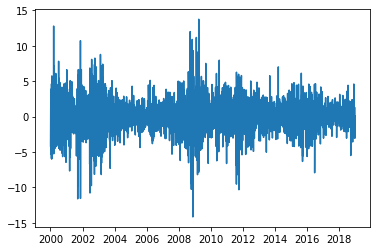

In [10]:
resid_plt = plt.plot(res_ar3.resid)

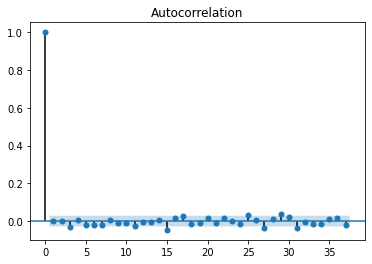

In [11]:
acf_plt = plot_acf(res_ar3.resid)

In [12]:
acorr_ljungbox(res_ar3.resid, lags=10, return_df=True)


,lb_stat,lb_pvalue
1,0.007814,0.929561
2,0.012893,0.993574
3,4.892334,0.179853
4,5.092980,0.277890
5,7.377311,0.194057
6,9.152604,0.165176
7,11.043139,0.136748
8,11.159331,0.192834
9,11.741895,0.228254
10,12.305598,0.265125


The residuals will be the new time series to work with. It can be interpreted as the log-returns but filtered for
linear dependencies.

In [13]:
log_return_adj_closed_filtered = res_ar3.resid


## Test for ARCH/GARCH effects

Intuitively, strong serial correlation should still exist in the filtered time series but in terms of squared returns.
For that plot the acf of the squared filtered returns and verify this by applying the Ljung-Box Test for serial
correlation again.


,lb_stat,lb_pvalue
1,135.098795,3.141423e-31
2,308.541811,1.002299e-67
3,502.681729,1.251692e-108
4,683.467898,1.323698e-146
5,786.830490,8.170064e-168
6,877.629493,2.574477e-186
7,988.013257,4.683838e-209
8,1073.153615,2.403412e-226
9,1152.587385,2.080078e-242
10,1247.074760,1.007362e-261


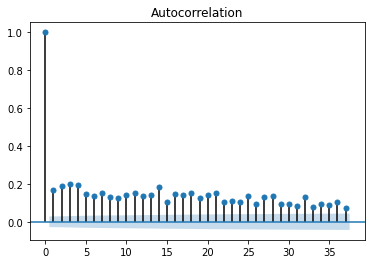

In [14]:
sqr_fil_returns = np.square(log_return_adj_closed_filtered)

acf_plt = plot_acf(sqr_fil_returns)

acorr_ljungbox(sqr_fil_returns, lags=10, return_df=True)

Clearly in all cases the nullhypothesis is rejected.

## Fitting a GARCH(1,1) model

In [15]:
mod_garch11 = arch_model(log_return_adj_closed_filtered, p=1, q=1, dist='normal')
res_garch11 = mod_garch11.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 9737.990809232448
Iteration:      2,   Func. Count:     16,   Neg. LLF: 9737.06601203421
Iteration:      3,   Func. Count:     23,   Neg. LLF: 9731.24205673007
Iteration:      4,   Func. Count:     30,   Neg. LLF: 9727.552469500797
Iteration:      5,   Func. Count:     37,   Neg. LLF: 9723.598868532947
Iteration:      6,   Func. Count:     44,   Neg. LLF: 9713.887400276977
Iteration:      7,   Func. Count:     51,   Neg. LLF: 9712.555314549867
Iteration:      8,   Func. Count:     58,   Neg. LLF: 9711.114302163809
Iteration:      9,   Func. Count:     65,   Neg. LLF: 9710.72427615578
Iteration:     10,   Func. Count:     72,   Neg. LLF: 9710.32753225473
Iteration:     11,   Func. Count:     78,   Neg. LLF: 9710.272158766944
Iteration:     12,   Func. Count:     84,   Neg. LLF: 9710.267560714487
Iteration:     13,   Func. Count:     90,   Neg. LLF: 9710.26752889144
Optimization terminated successfully.    (Exit mode 0)
            Cu

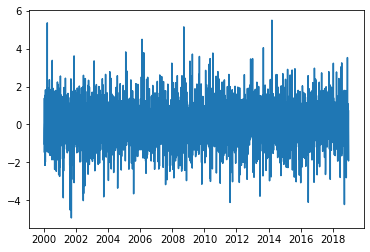

In [16]:
# standardized residuals = returns/conditional volatility

plt.plot(res_garch11.std_resid)
plt.show()


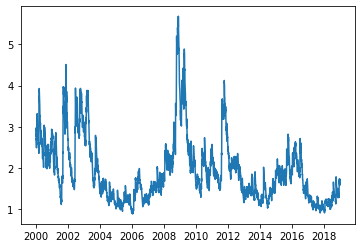

In [17]:
# conditional volatility

plt.plot(res_garch11.conditional_volatility)
plt.show()

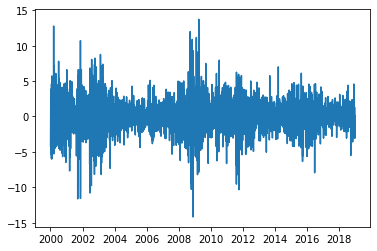

In [18]:
# unstandardized residuals = conditional volatility*standard white noise

plt.plot(res_garch11.resid)
plt.show()


In order to assess the quality of the fit, we have to evaluate how many predicted datapoints lie within a given confidence
intervall. In our example with normal distribution, the "coverage" can be simply calculate by $1.96 * \hat{\sigma_t}$.



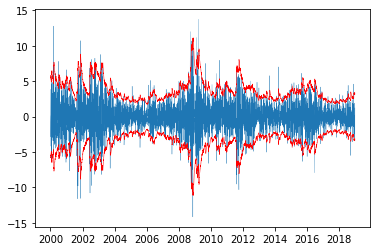

In [19]:
coverage_pos = res_garch11.conditional_volatility * 1.96
coverage_neg = - coverage_pos

fig, ax = plt.subplots()

# Customize data mapping appearance
ax.plot(log_return_adj_closed_filtered, linewidth = 0.3)
ax.plot(coverage_pos, linewidth=0.5, color='red')
ax.plot(coverage_neg, linewidth=0.5, color='red')
plt.show()


In [20]:
pos_exedence = coverage_pos < log_return_adj_closed_filtered
neg_exedence = coverage_neg > log_return_adj_closed_filtered
(pos_exedence.sum() + neg_exedence.sum())/len(log_return_adj_closed_filtered)


0.054797353184449955

We can see that our model roughly covers 95% of our sample which is for purpose good enough.


## Forecasting Volatility

Let us now do some mean and volatility forecast. The ARCH package has a forecast object for this task. Be default
forecasts will only be produced for the final observation in the sample so that they are out-of-sample.


In [21]:
obj_forecast = res_garch11.forecast()

print(obj_forecast.mean.iloc[-3:])
print(obj_forecast.residual_variance.iloc[-3:])
print(obj_forecast.variance.iloc[-3:])


                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28  0.024444
                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28  2.844671
                 h.1
Date                
2018-12-21       NaN
2018-12-27       NaN
2018-12-28  2.844671


In [22]:
obj_forecast = res_garch11.forecast(horizon=3)

print(obj_forecast.mean.iloc[-3:])
print(obj_forecast.residual_variance.iloc[-3:])
print(obj_forecast.variance.iloc[-3:])

                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28  0.024444  0.024444  0.024444
                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28  2.844671  2.852401  2.860093
                 h.1       h.2       h.3
Date                                    
2018-12-21       NaN       NaN       NaN
2018-12-27       NaN       NaN       NaN
2018-12-28  2.844671  2.852401  2.860093
